# Install and load dependencies

In [8]:
%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit
%pip install gseapy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz
from gseapy.plot import gseaplot


import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import sys
import gseapy as gp

sys.setrecursionlimit(10000)  # Set a higher recursion limit (adjust the value as needed)

# Run DeSeq2

In [10]:
merged = pd.read_csv('../data/raw/primary_unDiffs.tsv', delimiter='\t')
merged.set_index(merged.columns[0], inplace=True)
merged.sort_index(inplace=True)
merged *= 100
merged = merged.astype(int)

In [11]:
labels = ['LV'] * 5 + ['hiPSC'] * 7

metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [12]:
dds = DeseqDataSet(counts=merged,
            metadata=metadata,
            design_factors="Condition")

In [13]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/shahjess/anaconda3/lib/python3.11/site-pac

In [14]:
stat_res = DeseqStats(dds, contrast = ('Condition','LV','hiPSC'))

stat_res.summary()
res = stat_res.results_df


Running Wald tests...


Log2 fold change & Wald test p-value: Condition LV vs hiPSC
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG       102.426500       -1.290146  1.029633  -1.253015   2.102002e-01   
A1BG-AS1    27.692567        1.847327  0.473629   3.900369   9.604606e-05   
A1CF         0.712850       -1.831801  2.403549  -0.762123   4.459864e-01   
A2M       6878.865646       13.533685  0.493715  27.411915  1.977635e-165   
A2M-AS1    143.467731        4.192058  0.311669  13.450372   3.063258e-41   
...               ...             ...       ...        ...            ...   
ZXDB       296.052277       -0.843724  0.248866  -3.390277   6.982211e-04   
ZXDC       650.266972       -0.292301  0.222954  -1.311037   1.898454e-01   
ZYG11B     820.279729        0.318811  0.386487   0.824894   4.094315e-01   
ZYX       4652.875599        0.109768  0.561672   0.195430   8.450561e-01   
ZZEF1      427.460548        1.910809  0.162482  11.760099   6.266094e-32   

               

... done in 0.52 seconds.



# Heat Map

/Users/shahjess/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shahjess/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


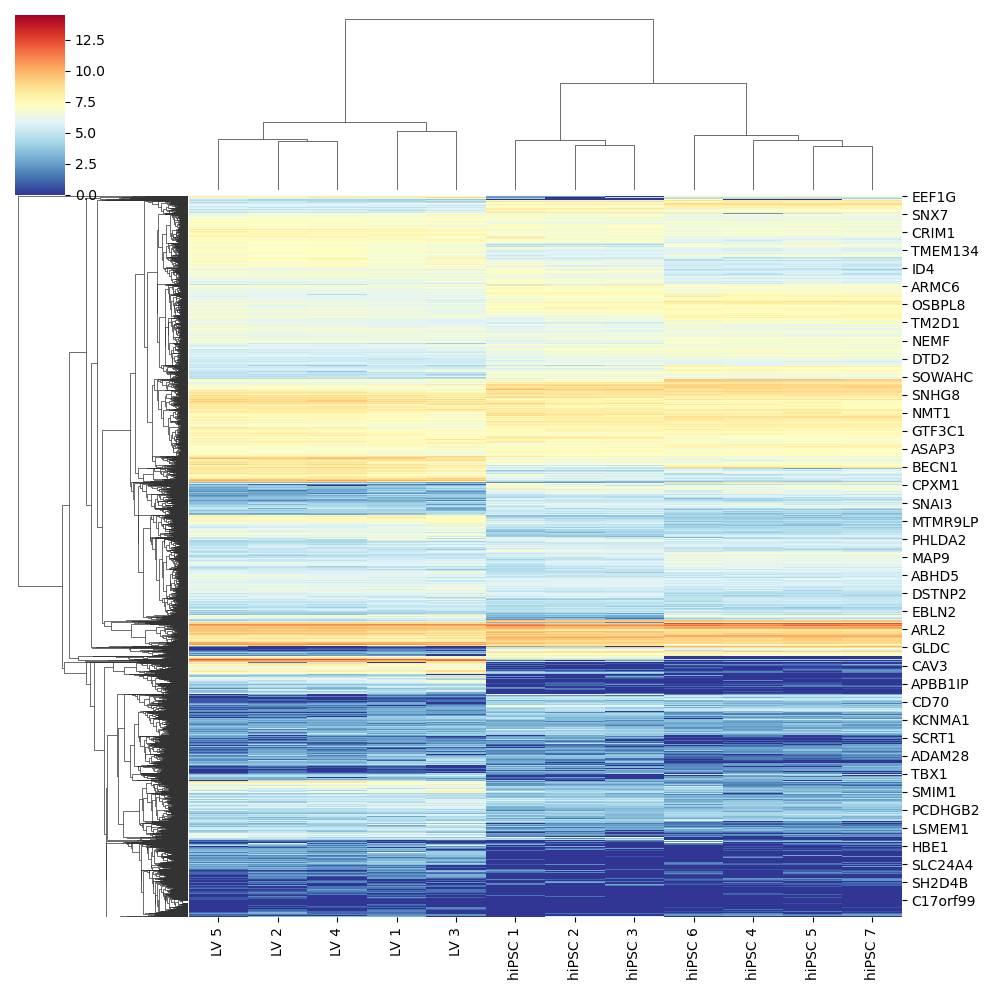

In [15]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_res = dds[:, res.index]

pattern_repetitions = {'LV': 5, 'hiPSC': 7}
col_labels = [f'{pattern} {i}' for pattern, repetitions in pattern_repetitions.items() for i in range(1, repetitions + 1)]

grapher_res = pd.DataFrame(dds_res.layers['log1p'].T,
                       index=dds_res.var_names, columns=col_labels)

sns.clustermap(grapher_res, cmap='RdYlBu_r')

# Heatmap of cardiac genes

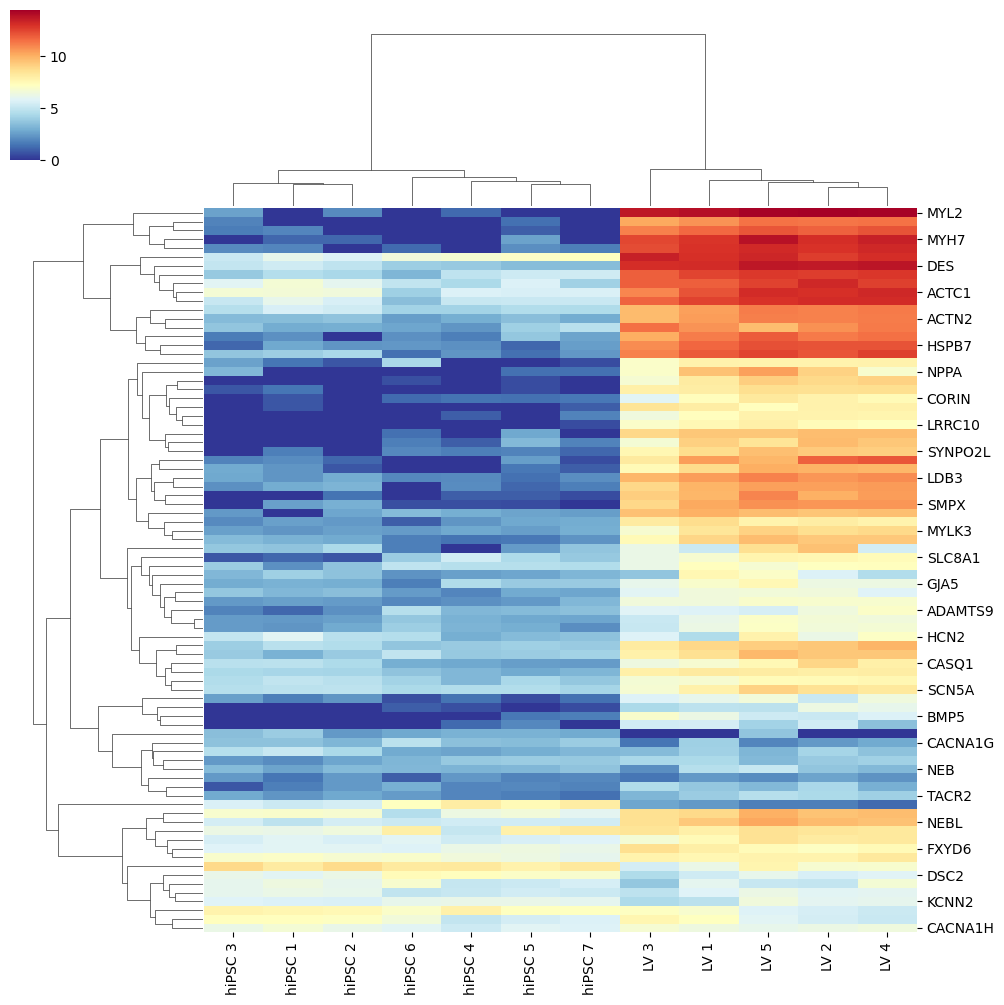

In [16]:
cardiac_genes = pd.read_csv('../data/raw/cardiac_genes.csv', delimiter='\t')
common_genes = cardiac_genes['Gene'][cardiac_genes['Gene'].isin(grapher_res.index)]
subset_grapher_res = grapher_res.loc[common_genes]

sns.clustermap(subset_grapher_res, cmap='RdYlBu_r',cbar_pos=(0, .85, .03, .15))
plt.savefig('../figures/Fig S2a LV hiPSC Cardiac Heatmap.png')

# Differentially Expressed Genes

In [17]:
#Filter based on p-value
ranking = res[res['pvalue'] <= 0.05]

#Sort based on abs log2 fold change
ranking = ranking[['log2FoldChange']].dropna()
ranking['abs_l2FC'] = ranking['log2FoldChange'].abs()
ranking.sort_values(by='abs_l2FC', ascending=False, inplace=True)
ranking = ranking[ranking['abs_l2FC'] > 1]

ranking.drop(columns=['abs_l2FC'], inplace=True)


ranking

,log2FoldChange
MYL2,18.957819
MYH7,17.875694
LIN28A,-17.516846
ANKRD2,17.502803
HSPB3,17.437420
...,...
MANEA,-1.001432
B3GAT3,1.001179
SSU72,-1.001070
VPS4B,-1.000993


In [18]:
#Filter based on p-value
ranking = res[res['pvalue'] <= 0.05]

#Sort based on abs log2 fold change
ranking = ranking[['log2FoldChange']].dropna()
ranking['abs_l2FC'] = ranking['log2FoldChange'].abs()
ranking.sort_values(by='abs_l2FC', ascending=False, inplace=True)
ranking = ranking[ranking['abs_l2FC'] > 5]

ranking.drop(columns=['abs_l2FC'], inplace=True)


ranking

,log2FoldChange
MYL2,18.957819
MYH7,17.875694
LIN28A,-17.516846
ANKRD2,17.502803
HSPB3,17.437420
...,...
FOSL2,5.009478
SHOX2,5.007829
SOX4,-5.001473
SNX10,-5.000621


In [19]:
pre_res = gp.prerank(rnk=ranking, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2021',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2024-04-12 17:22:57,011 [INFO] Parsing data files for GSEA.............................
2024-04-12 17:22:57,011 [INFO] Enrichr library gene sets already downloaded in: /Users/shahjess/.cache/gseapy, use local file
2024-04-12 17:22:57,049 [INFO] 4622 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-12 17:22:57,050 [INFO] 1414 gene_sets used for further statistical testing.....
2024-04-12 17:22:57,051 [INFO] Start to run GSEA...Might take a while..................
2024-04-12 17:22:59,644 [INFO] Congratulations. GSEApy runs successfully................



In [20]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes'],
               pre_res.results[term]['gene %'],
               pre_res.results[term]['lead_genes'],])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes','gene %','lead_genes']).sort_values('nes').reset_index(drop = True)

out_df['abs_nes'] = abs(out_df['nes'])  # Create a new column with absolute NES values
out_df = out_df.sort_values('nes', ascending=False).reset_index(drop=True)

out_df.drop('abs_nes', axis=1, inplace=True)

# out_df.to_csv('GSEA/OG_primary_new.tsv', sep='\t', index=False)

out_df

,Term,fdr,es,nes,gene %,lead_genes
0,muscle contraction (GO:0006936),0.0,0.658477,3.651131,20.02%,MYL2;MYH7;ANKRD2;CASQ2;MYL3;MYBPC3;LMOD2;KLHL4...
1,actin-myosin filament sliding (GO:0033275),0.0,0.712283,3.099134,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;DES;TCAP;TNNT3;TNNT...
2,muscle filament sliding (GO:0030049),0.0,0.712283,3.099134,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;DES;TCAP;TNNT3;TNNT...
3,myofibril assembly (GO:0030239),0.0,0.667500,3.077533,13.57%,MYL2;MYOZ2;CSRP3;LMOD2;KLHL41;MYH6;LMOD3;TCAP;...
4,striated muscle contraction (GO:0006941),0.0,0.692523,3.059620,8.89%,MYH7;CASQ2;MYL3;MYBPC3;CSRP3;KLHL41;MYH6;LMOD3...
...,...,...,...,...,...,...
1409,regulation of cell cycle process (GO:0010564),0.0,-0.638050,-3.363012,23.83%,CDC25C;NEK2;INSM1;BUB1;RMI2;AURKB;KIF20A;MKI67...
1410,mitotic metaphase plate congression (GO:0007080),0.0,-0.819745,-3.433488,18.55%,KIF14;KIF18A;CDT1;CENPE;NUF2;CEP55;CCNB1;NDC80...
1411,mitotic sister chromatid segregation (GO:0000070),0.0,-0.694270,-3.814665,22.66%,DLGAP5;KIF14;KIF18A;NCAPG;CENPE;CENPK;CEP55;NC...
1412,mitotic spindle organization (GO:0007052),0.0,-0.734623,-4.674447,27.73%,DLGAP5;KIF18A;TTK;CENPF;BUB1B;BUB1;BIRC5;AURKB...


In [21]:
filtered_df = out_df[out_df['Term'].str.contains('heart|cardiac', case=False)]

filtered_df

,Term,fdr,es,nes,gene %,lead_genes
5,heart development (GO:0007507),0.000000,0.547239,2.997631,21.58%,MYL2;MYH7;MYBPC3;CSRP3;MYH6;TBX2;TCAP;SOX17;LD...
6,heart contraction (GO:0060047),0.000000,0.681185,2.949607,18.99%,MYL2;MYH7;CASQ2;MYL3;MYBPC3;CSRP3;MYH6;TCAP;TN...
9,ventricular cardiac muscle tissue development ...,0.000000,0.746015,2.727612,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;HOPX;TNNT2;TNNC1;HA...
10,regulation of heart contraction (GO:0008016),0.000000,0.587727,2.713109,14.89%,CASQ2;MYH6;HSPB7;TNNI3K;DES;PLN;TBX2;NKX2-5;TN...
11,cardiac muscle tissue morphogenesis (GO:0055008),0.000000,0.636256,2.704113,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;TCAP;NKX2-5;TNNT2;T...
12,cardiac muscle contraction (GO:0060048),0.000164,0.630805,2.522474,8.89%,MYH7;CASQ2;MYL3;MYBPC3;CSRP3;MYH6;TCAP;TNNT2;T...
13,ventricular cardiac muscle tissue morphogenesi...,0.000228,0.630899,2.500862,8.64%,MYL2;MYH7;MYL3;MYBPC3;MYH6;NKX2-5;TNNT2;TNNC1;...
14,cardiac muscle cell development (GO:0055013),0.000354,0.685770,2.486907,23.97%,MYL2;CSRP3;MYH6;LRRC10;TCAP;NKX2-5;ACTC1;ALPK2...
15,adult heart development (GO:0007512),0.000664,0.951052,2.440476,5.13%,MYH7;MYH6;TCAP;NKX2-5;HAND2
19,regulation of cardiac conduction (GO:1903779),0.002711,0.687870,2.337051,14.89%,CASQ2;TNNI3K;NKX2-5;NPPA;FXYD1;AGT;CORIN;ACE2


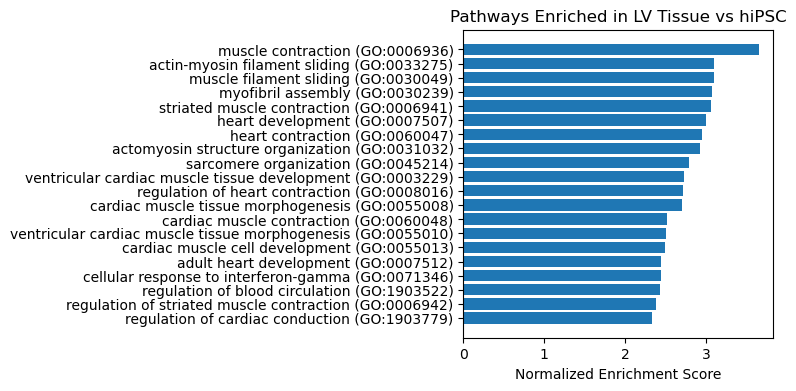

<Figure size 640x480 with 0 Axes>

In [22]:
og_primary = out_df
og_primary = og_primary.sort_values('nes', key=lambda x: x, ascending=False)

sig = og_primary[og_primary['fdr'] <= 0.05]

# 20 necessary paths
good_paths = sig.iloc[0:20]

fig, ax = plt.subplots(figsize=(4, 4))  # 8x8 inches for example

# Example data
gos = good_paths['Term']
nes = abs(good_paths['nes'])
y_pos = np.arange(len(nes))

ax.barh(y_pos, nes, align='center')
ax.set_yticks(y_pos, labels=gos)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Normalized Enrichment Score')
ax.set_title('Pathways Enriched in LV Tissue vs hiPSC')

plt.show()
plt.savefig('../figures/Fig S2b Pathways LV hiPSC.png')

